In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

import Rung as rung

from pandas_datareader import wb

import seaborn as sns


import seaborn as sns
import feature_finder_keiko as ff
import feature_finder_f as ff1

from scipy import signal

plt.rcParams["figure.figsize"] = (20,10)

Could not import rpy package
Could not import r-package RCIT


In [2]:
def PCA_computer_rotated_locs(file_name, code, temporal_limits,n_components_sst=98, missing_value=-9.96921e+36):
    sst = Data(file_name,code,temporal_limits, missing_value= missing_value)

    result = sst.get_data()
    lon_sst_list = sst.get_lon_list()
    lat_sst_list = sst.get_lat_list()
    lon_sst = sst.get_lon()
    lat_sst = sst.get_lat()

    result_sst, avgs, stds = pf.deseasonalize_avg_std(np.array(result))
    result_sst = signal.detrend(result_sst, axis=0)
    weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
    for i in range(len(weights)):
        result_sst[:,i] = weights[i] * result_sst[:,i]

    data_sst = pd.DataFrame(result_sst)
        
    V, U, S, ts, eig, explained, max_comps = rung.pca_svd(data_sst,truncate_by='max_comps', max_comps=n_components_sst)
        
    Vr, Rot = rung.varimax(V)
    Vr = rung.svd_flip(Vr)

    # Get explained variance of rotated components
    s2 = np.diag(S)**2 / (ts.shape[0] - 1.)

    # matrix with diagonal containing variances of rotated components
    S2r = np.dot(np.dot(np.transpose(Rot), np.matrix(np.diag(s2))), Rot)
    expvar = np.diag(S2r)

    sorted_expvar = np.sort(expvar)[::-1]
    # s_orig = ((Vt.shape[1] - 1) * s2) ** 0.5

    # reorder all elements according to explained variance (descending)
    nord = np.argsort(expvar)[::-1]
    Vr = Vr[:, nord]

    # Get time series of UNMASKED data
    comps_ts = np.matmul(np.array(data_sst),Vr)

    df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list})

    lon_temp = df_sst["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df_sst["lons"].vlues = lon_temp
    
    return(result_sst, comps_ts, Vr, df_sst, lon_sst, lat_sst)

In [3]:
step = 1
train_start = np.arange(1948,1977,step)
#train_end = np.arange(1955,2006,step)
validation_end = np.arange(1982,2011,step)
test_start = np.arange(1983,2012,step)
test_end = np.arange(1987,2016,step)

In [4]:
n_components_sst = np.load("sst_number.npy")
tau = 12
f = 12
level = 99

In [5]:
temporal_limits = {"time_min":datetime(train_start[0], 1, 1, 0, 0),"time_max":datetime(validation_end[0], 12, 1, 0, 0)}
lon1_sst = np.arange(-180,180,2)
data_sst, ts, V, df_sst, lon_sst, lat_sst = PCA_computer_rotated_locs('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst[0], -9.96921e+36)
deg_result = np.zeros((len(lat_sst),len(lon1_sst)))

In [14]:
for tau in np.arange(1,13)
    for ijz in range(4):
        temporal_limits = {"time_min":datetime(train_start[ijz], 1, 1, 0, 0),"time_max":datetime(validation_end[ijz], 12, 1, 0, 0)}
        data_sst, ts, V, df_sst, _, _ = PCA_computer_rotated_locs('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst[ijz], -9.96921e+36)
        pcmci = np.load("../../whole_data_results/ZW/best_link/pcmci_{}_{}_{}_{}_{}.npy".format(f,train_start[ijz],validation_end[ijz],tau,n_components_sst[ijz]))
        comps = pcmci[:,0]

        lat_number = len(lat_sst)
        lon_number = len(lon1_sst)

        for comp in set(comps):
            deg = np.zeros((len(lat_sst),len(lon1_sst)))
            df_sst["pc"] = V[:,comp-1]
            for i in range(lat_number):
                for j in range(lon_number):
                    if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values.size == 0:
                        deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
                    else:
                        deg[i,j]=np.nan


            if np.abs(np.nanmin(deg)) > np.abs(np.nanmax(deg)):
                limit = np.nanpercentile(deg, 1 - level)
                deg[deg>=limit]=0
                deg[deg<limit]=1
            else:
                limit = np.nanpercentile(deg, level)
                deg[deg<=limit]=0
                deg[deg>limit]=1

            deg_result = deg_result + deg 

In [32]:
class_name = "BSh"
cc = "ET"
tau = 12
deg_result = np.load("../../whole_data_results/NE/areas/pcmci_{}_{}_{}_{}_{}.npy".format(f,step,test_start[0],test_end[-1],tau))
#deg_result = np.load("../../whole_data_results/ET_orac/areas_{}/pcmci_{}_{}_{}_{}_{}.npy".format(class_name,f,step,test_start[0],test_end[-1],tau))

In [19]:
deg_result = np.zeros(deg_result1.shape)
deg_result[deg_result1 > 6] = 1

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


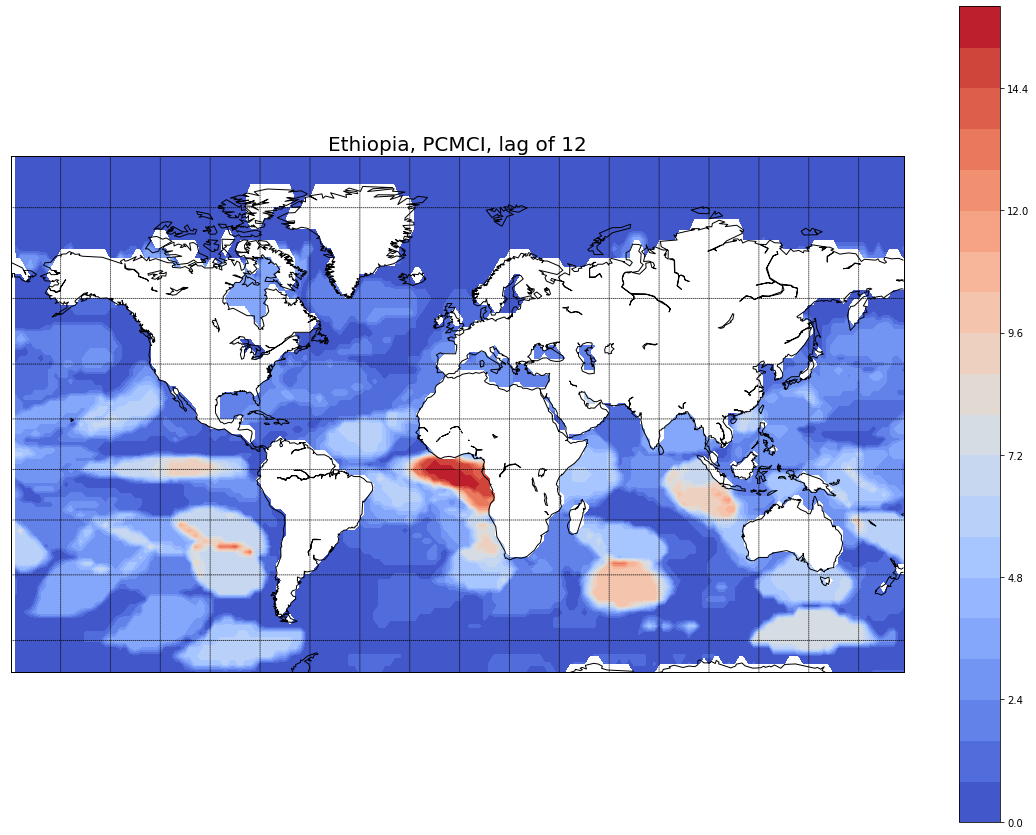

In [33]:
    #deg_result[deg_result > 0] = 1

    lon  = lon1_sst
    lat = lat_sst
    m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon1_sst.min(), \
      urcrnrlon=lon1_sst.max(),llcrnrlat=lat_sst.min()+20,urcrnrlat=lat_sst.max(), \
      resolution='c')

    lon2, lat2 = np.meshgrid(lon,lat)
    x, y = m(lon2, lat2)
    x, y = m(lon2, lat2)
    fig = plt.figure(figsize=(20,15))
    #m.fillcontinents(color='gray',lake_color='gray')
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.drawmapboundary(fill_color='white')
    cs = m.contourf(x,y,deg_result,20,cmap=plt.cm.get_cmap('coolwarm'))
    plt.title('Ethiopia, PCMCI, lag of {}'.format(tau),fontsize=20)
    #cbar.ax.tick_params(labelsize=25)
    plt.colorbar();
    #plt.savefig("EOF{}.png".format(pc))
    #plt.savefig("./areas/{}_PCMCI_{}.png".format(cc,tau))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


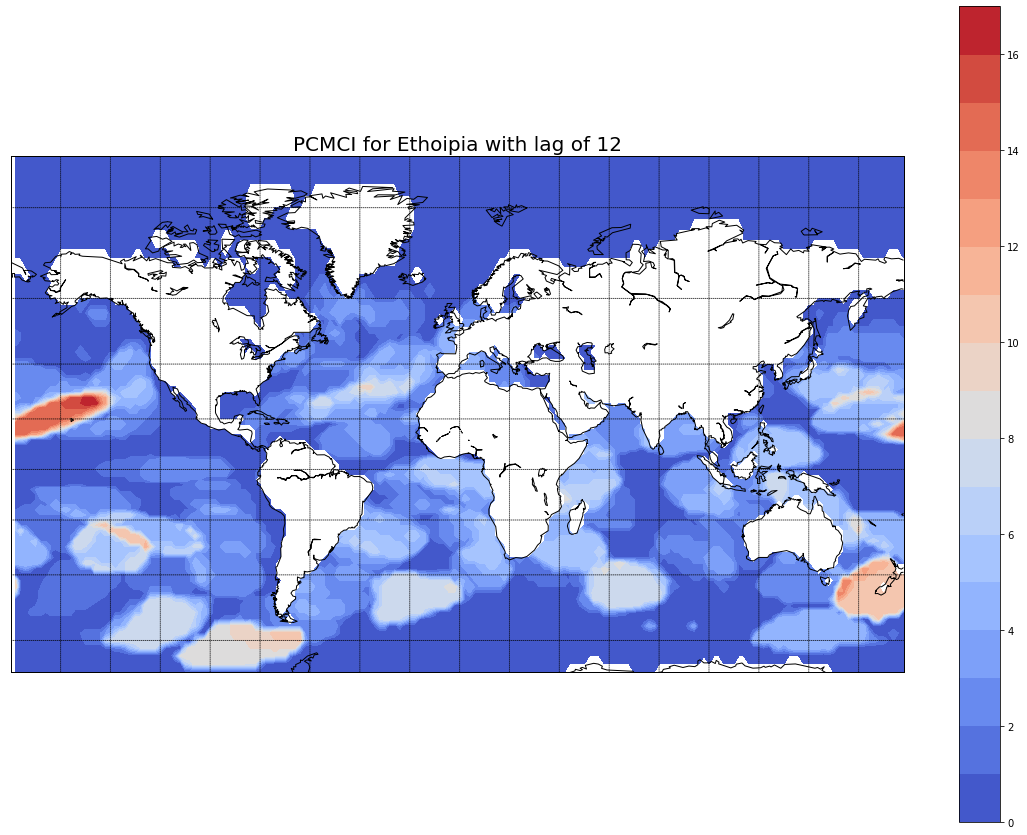

In [20]:
    #deg_result[deg_result > 0] = 1

    lon  = lon1_sst
    lat = lat_sst
    m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon1_sst.min(), \
      urcrnrlon=lon1_sst.max(),llcrnrlat=lat_sst.min()+20,urcrnrlat=lat_sst.max(), \
      resolution='c')

    lon2, lat2 = np.meshgrid(lon,lat)
    x, y = m(lon2, lat2)
    x, y = m(lon2, lat2)
    fig = plt.figure(figsize=(20,15))
    #m.fillcontinents(color='gray',lake_color='gray')
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.drawmapboundary(fill_color='white')
    cs = m.contourf(x,y,deg_result,20,cmap=plt.cm.get_cmap('coolwarm'))
    plt.title('PCMCI for Ethoipia with lag of {}'.format(tau),fontsize=20)
    #cbar.ax.tick_params(labelsize=25)
    plt.colorbar();
    #plt.savefig("EOF{}.png".format(pc))
    plt.savefig("./areas/{}_PCMCI_{}.png".format(cc,tau))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


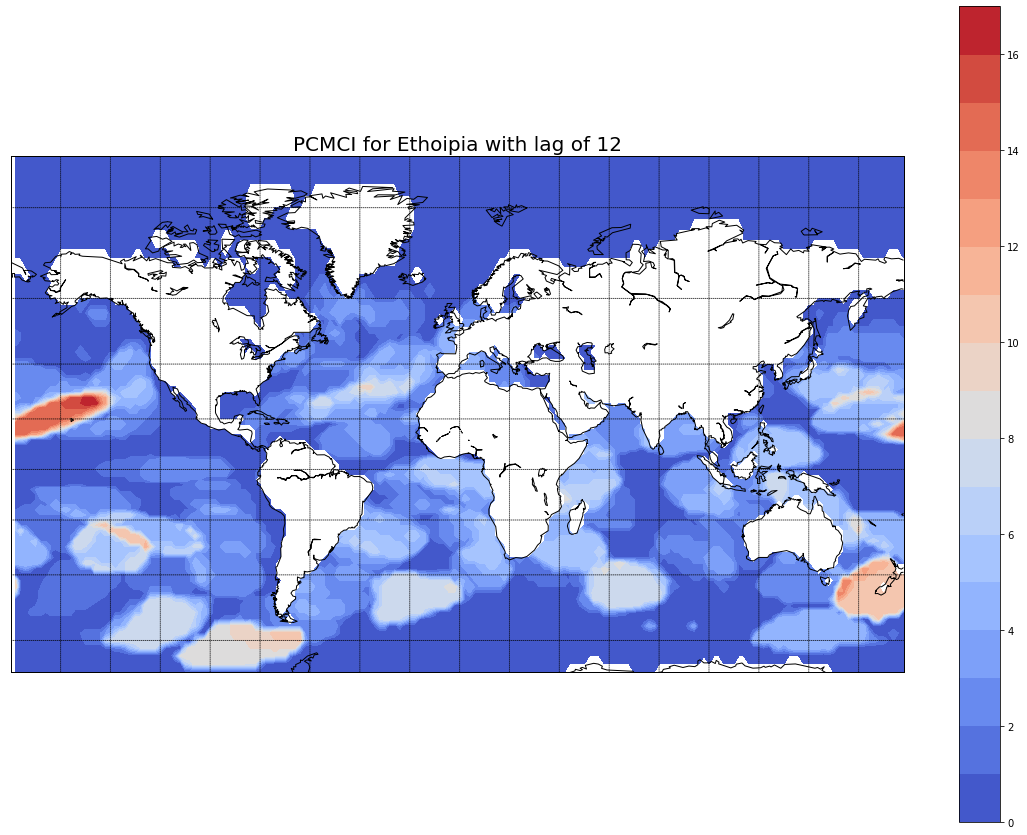

In [17]:
    #deg_result[deg_result > 0] = 1

    lon  = lon1_sst
    lat = lat_sst
    m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon1_sst.min(), \
      urcrnrlon=lon1_sst.max(),llcrnrlat=lat_sst.min()+20,urcrnrlat=lat_sst.max(), \
      resolution='c')

    lon2, lat2 = np.meshgrid(lon,lat)
    x, y = m(lon2, lat2)
    x, y = m(lon2, lat2)
    fig = plt.figure(figsize=(20,15))
    #m.fillcontinents(color='gray',lake_color='gray')
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.drawmapboundary(fill_color='white')
    cs = m.contourf(x,y,deg_result,20,cmap=plt.cm.get_cmap('coolwarm'))
    plt.title('PCMCI for Ethoipia with lag of {}'.format(tau),fontsize=20)
    #cbar.ax.tick_params(labelsize=25)
    plt.colorbar();
    #plt.savefig("EOF{}.png".format(pc))
    #plt.savefig("./areas/{}_PCMCI_{}.png".format(cc,tau))